In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

import mass
from numpy.typing import NDArray

matplotlib.rcParams['font.size'] = 20

In [3]:
# DEFINITIONS
KEV_TO_U    = 931494.061  # keV / Da
MEV_TO_U    = 931.494061  # MeV / c^2
RHO_M       = 0.5         # Radius of curvature / meters
MEVC_NWSEC  = 5.56e-22    # Converts to Ns (Newtons.sec) [Mag. field in Tesla]
ELMNTR_CHRG = 1.6e-19     # Elementary charge / C(oloumb)
E0_MEV      = 0.03        # Ion beam energy / MeV
DISP        = 2700        # Dispersion of the Separator system / mm
Mx          = 1.14        # Magnification of the Separator system / unitless
ALPHA_X_CS  = 0           # Courant-Snyder alpha (Twiss) unitless
BETA_X_CS   = 0.08135     # Courant-Snyder beta  (Twiss) meters
EPS         = 10 
GAMMA_X_TWISS = (1 + ALPHA_X_CS**2) / BETA_X_CS

# REFERENCE FOR MAGNET SYSTEM CALCULATIONS
# [1] THE OPTICS OF DIPOLE MAGNETS BY JOHN LIVINGOOD (1969)

# NOTES:
# [1] AMOTIC MASS EVALUATION - Chinese Phys. C 45, 030002 (2021)
#                            - Chinese Phys. C 45, 030003 (2021)
# [2] The ISOLDE Yield Database, Version 0.2, 
#     https://cern.ch/isolde-yields, 2019, [Online; accessed 25.10.2024]
# [3] DEFINITIONS OF IMAGE WIDTH MAY VARY. HERE I ADOPT THE 2*FWHM = 2*2.355*STDV

In [4]:
def selected_resolving_power(iso1: float, iso2: float) -> float:
    return iso1 / (iso1 - iso2)

In [5]:
def resolving_power(series: pd.Series, el: str, am: int) -> pd.Series:
    if series.iloc[0]['A'] == am:
        print(series[series['EL'] == el]['ame_tot'].to_numpy()[0])
        lightest = series[series['EL'] == el]['ame_tot'].to_numpy()[0]
    else:
        lightest = series['ame_tot'].min()
    new_column = lightest / np.abs(series['ame_tot'] - lightest)
    # print(new_column)
    return new_column

In [6]:
def gauss(x: NDArray, mu: float, sigma: float) -> NDArray:
    z = (x - mu) / sigma
    norm = 1 / (sigma * np.sqrt(2 * np.pi))
    arr = norm * np.exp( -0.5 * z * z )
    return arr

In [7]:
def gen_multi_gauss(mean: float, cov: NDArray, weight: float) -> NDArray:
    # Fixing random state for reproducibility
    np.random.seed(19680801)
    nevents = 5_000
    isol_yield = int(nevents*weight) if int(nevents*weight) != 0 else 1
    return np.random.multivariate_normal(mean, cov, size=isol_yield).T

In [8]:
# ==============================================================================
# LOAD AME2020 (NOTES [1])
# ==============================================================================
ame_obj = mass.Ame()
ame_obj.load_table()
# ==============================================================================
# Add some extra masses to the table
# ==============================================================================
molecules = ['1N16:1O16', '1N16:1N16', '1O15:1O17', '1N15:1N17', '1N18:1N14']
for molec in molecules:
    ame_obj.add_entry_table(molec)
ame_obj.df[ame_obj.df['A'] == 32]

,N,Z,A,EL,ME,MEunc,amunc,ame_tot,charge
212,22,10,32,Ne,36999.,503.,540.000000,3.203972e+07,1
213,21,11,32,Na,18640.152,37.260,40.000000,3.202001e+07,1
214,20,12,32,Mg,-828.901,3.260,3.500000,3.199911e+07,1
215,19,13,32,Al,-11099.368,7.173,7.700000,3.198808e+07,1
216,18,14,32,Si,-24077.689,0.298,0.320000,3.197415e+07,1
217,17,15,32,P,-24304.876,0.040,0.042000,3.197391e+07,1
218,16,16,32,S,-26015.53714,0.00131,0.001410,3.197207e+07,1
219,15,17,32,Cl,-13334.706,0.562,0.603000,3.198568e+07,1
220,14,18,32,Ar,-2200.352,1.770,1.900000,3.199764e+07,1
221,13,19,32,K,21990.,400.,429.000000,3.202361e+07,1


In [9]:
ame_table = ame_obj.df
grp = ame_table.groupby('A', as_index=False)
r = grp.apply(resolving_power, 'Ar', 32)
ame_table['R'] = r.reset_index(level=0, drop=True)
ame_table.replace([np.inf, -np.inf], np.nan, inplace=True)


31997637.824


In [10]:
arg = 2 * ame_table['ame_tot']/1e6 * MEV_TO_U * E0_MEV
ame_table['Breq_T'] = (np.sqrt(arg) / RHO_M / ELMNTR_CHRG) * MEVC_NWSEC
ame_table['Ref_mom'] = np.sqrt(arg)
ame_table[ame_table['A'] == 32][['EL', 'R']]

,EL,R
212,Ne,760.360819
213,Na,1430.177079
214,Mg,21732.889740
215,Al,3349.315404
216,Si,1362.396669
217,P,1348.394175
218,S,1251.538127
219,Cl,2676.905512
220,Ar,NaN
221,K,1232.139126


In [11]:
# ==============================================================================
# LOAD YIELD DATABASE - SEE NOTES [2]
# ==============================================================================
iso_df = pd.read_csv('./isol_yield.csv')
print(iso_df.columns)
iso_df['TARGET_NAME'].unique()

Index(['YIELD_ID', 'A', 'Z', 'INTENSITY', 'METASTABILITY', 'TARGET_NAME',
       'INTENSITY_ESTIMATION_METHOD', 'HALFLIFE'],
      dtype='object')


array(['U Carbide', 'ZrO2 fibers', 'TiOx fibers',
       'Th/Ta Metal foil/powder', 'Th Oxide', 'Th Carbide', 'Ta foil',
       'SrO powder', 'Pb Molten metal', 'BeO porous pellets ca. 50%',
       'Ca Oxide', 'CaO powder', 'CeOx fibers', 'Ge Molten metal',
       'La Molten metal', 'La2O3 powder', 'Mg Oxide', 'Nb foil',
       'Ba Oxide', 'Zr Metal foil', 'Ti Metal foil', 'Ta foil thin',
       'Ir powder', 'Ta foil rolls', 'Ta foil discs',
       'Irradiated graphite from PSI', 'C Multiwalled nanotubes',
       'HfO2 fibers', 'NaFLiF salt', 'CaO nanostructured powder',
       'Pt Metal/graphite mix', 'Si Carbide', 'SiC sub-micron',
       'Sc Carbide', 'ZrO2 felt', 'Ta/Nb Metal powder',
       'Ta Metal/graphite mix', 'V Carbide', 'Ca Boride', 'Ti Metal rod',
       'Ti Unknown', 'Ta Metal powder', 'Y2O3 submicron', 'Y2O3 powder',
       'Zr Oxide', 'Nb Metal powder', 'Th/Nb Metal powder',
       'Y2O3 pellets', 'PbBi molten metal', 'Sn Molten metal',
       'La Carbide', 'Te Chlorid

In [12]:
ame_sel = ame_table[ame_table['A'] == 32].copy(deep=True).reset_index()
target = 'CaO nanostructured powder'
condition = (iso_df['TARGET_NAME'] == target) & (iso_df['A'] == 32)
sel = iso_df[condition].copy(deep=True).reset_index() 

result = pd.merge(ame_sel, sel, how="outer", on=["Z", "A"])
result

,index_x,N,Z,A,EL,ME,MEunc,amunc,ame_tot,charge,R,Breq_T,Ref_mom,index_y,YIELD_ID,INTENSITY,METASTABILITY,TARGET_NAME,INTENSITY_ESTIMATION_METHOD,HALFLIFE
0,212,22,10,32,Ne,36999.,503.,540.000000,3.203972e+07,1,760.360819,0.294100,42.316528,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,213,21,11,32,Na,18640.152,37.260,40.000000,3.202001e+07,1,1430.177079,0.294009,42.303511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,214,20,12,32,Mg,-828.901,3.260,3.500000,3.199911e+07,1,21732.889740,0.293913,42.289702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215,19,13,32,Al,-11099.368,7.173,7.700000,3.198808e+07,1,3349.315404,0.293863,42.282415,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,216,18,14,32,Si,-24077.689,0.298,0.320000,3.197415e+07,1,1362.396669,0.293799,42.273206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3559,18,14,32,1N16:1N16,11367.813796,3.253809,3.493107,3.201220e+07,1,2196.730792,0.293974,42.298353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3561,18,14,32,1N15:1N17,7971.515908,14.999849,16.103000,3.200856e+07,1,2930.199958,0.293957,42.295944,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3562,18,14,32,1N18:1N14,15976.58303,18.569334,19.935000,3.201715e+07,1,1639.748838,0.293996,42.301622,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,217,17,15,32,P,-24304.876,0.040,0.042000,3.197391e+07,1,1348.394175,0.293798,42.273045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3558,17,15,32,1N16:1O16,946.904941,2.30079,2.470000,3.200102e+07,1,9470.342426,0.293922,42.290961,NaN,NaN,NaN,NaN,NaN,NaN,NaN


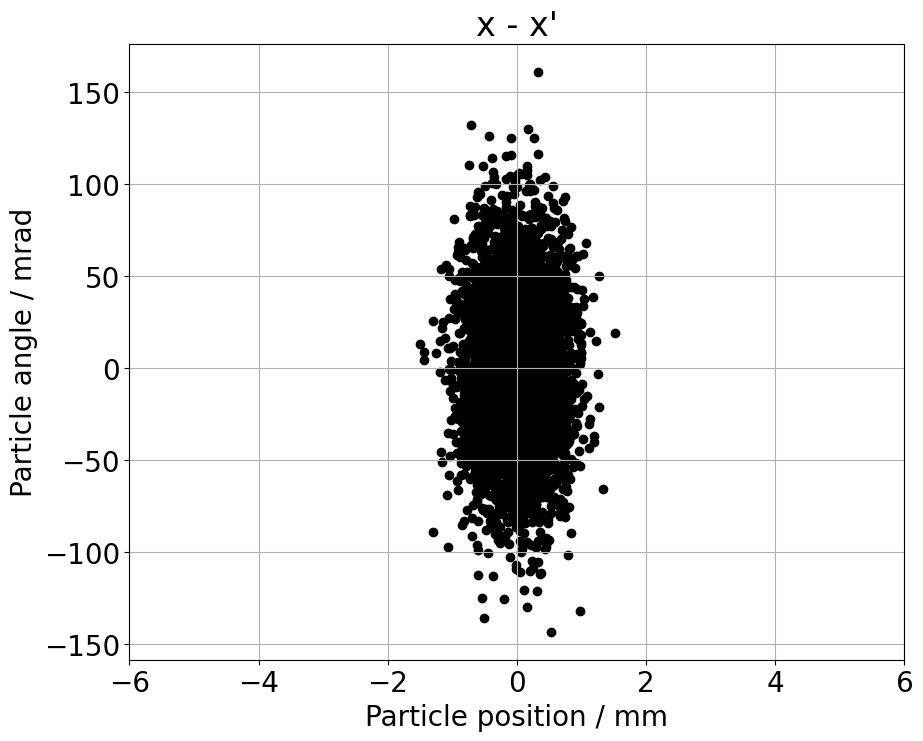

In [13]:
# ==============================================================================
# Beam initial conditions (i.e. focal plane of the magnet system)
# ==============================================================================
mean = (0, 0) # Center of Multivariate distribution around (0,0) point
# ==============================================================================
# CASE (A) If measurement of the beam distribution is available
std_x = 0.4   # mm
std_xp = 40   # mrad
rho = 0.      # For the beam waist the correlation should be 0
cov = [[std_x**2, rho*std_x*std_xp], 
       [rho*std_x*std_xp, std_xp**2]]
# ==============================================================================
# CASE (B) If Courant-Snyder parameters are available + emittace
# cov1 = [[BETA_X_TWISS, -ALPHA_X_TWISS], 
#         [-ALPHA_X_TWISS, GAMMA_X_TWISS]]
# cov = np.multiply(EPS, cov1)
# ==============================================================================
xlim = 6  # used for display maximum xrange
u, up = gen_multi_gauss(mean, cov, 1)
# ==============================================================================
fig0, ax0 = plt.subplots(figsize=(10, 8))
plt.sca(ax0)
plt.title('x - x\'')
plt.scatter(u, up, marker='o', c='k')

plt.xlim(-xlim, xlim)
plt.xlabel(f'Particle position / mm')
plt.ylabel('Particle angle / mrad')

plt.grid()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Text(0.07, 0.75, '$E_0$ = 30 keV\n$D$ = 2700 mm\n$M_x$ = 1.14 \n$\\epsilon_x$ = 10.0 $\\pi$ mm mrad\n$\\sigma_x$ = 0.4 mm\n$\\sigma_{p_x}$ = 40.0 mrad')

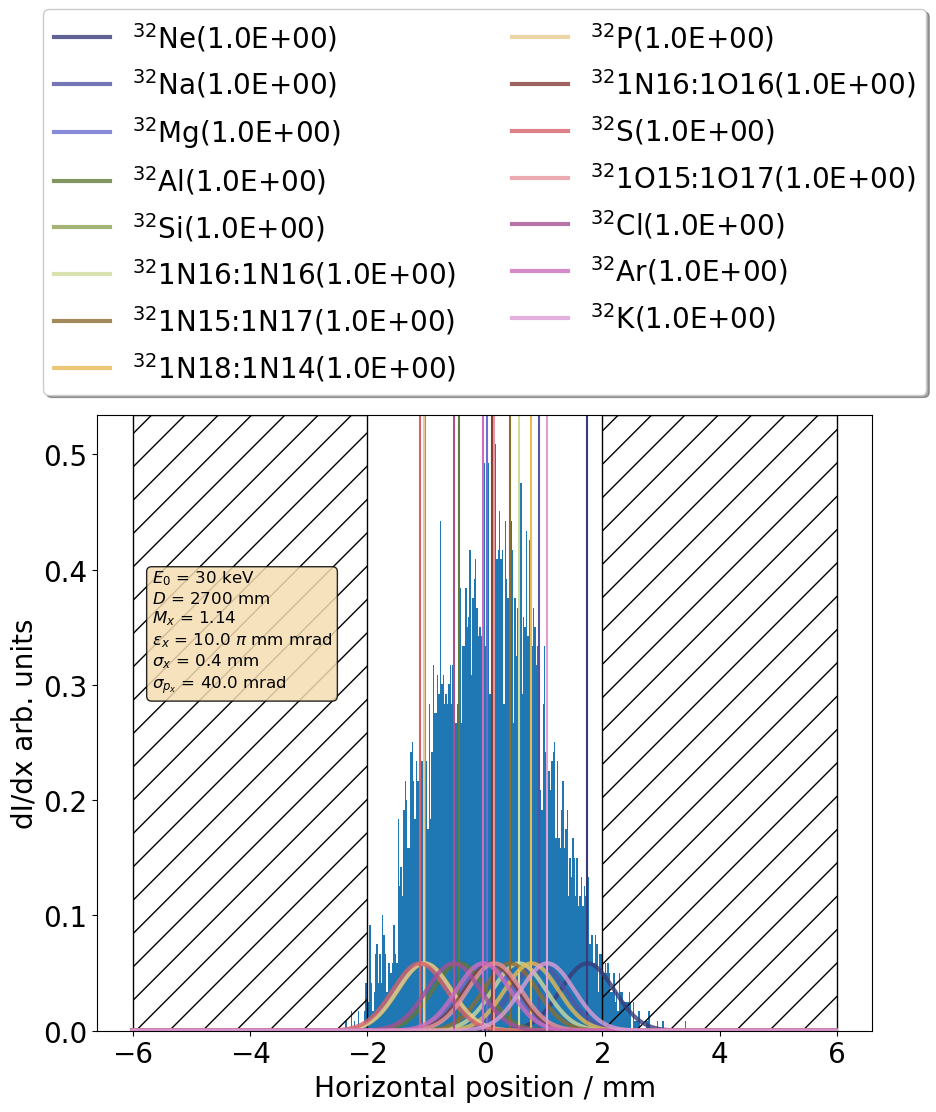

In [15]:
# ==============================================================================
# INPUT: REQUIRED ELEMENT & REQUIRED MASS
# ==============================================================================
req_z = 18
req_mass = 32
req_el = 'Ar'
# ==============================================================================
# SELECT THE REQUIRED MAGNETIC FIELD, ATOMIC MASS AND REFERENCE MOMENTUM
# ==============================================================================
cond = (result['A'] == req_mass) & (result['EL'] == req_el)
ref_B = result[cond]['Breq_T'].values[0]
ref_M = result[cond]['ame_tot'].values[0]
ref_P = result[cond]['Ref_mom'].values[0]
# ==============================================================================
# INPUT WEIGHTS FOR THE DISTRIBUTIONS 
# ==============================================================================
# PULL THE WHOLE ISOBARS AVAILABLE AT THIS MASS NUMBER
sel = result[result['A'] == req_mass]
chosen = sel['EL'].values
# IF INTERESTED IN PLOTTING ONLY PART OF THE ISOBARS
# chosen = ['Ar', '1N16:1O16', '1N16:1N16', '1O15:1O17', '1N15:1N17', '1N18:1N14']
# GET YIELD FROM TABLES AND SELECT APPROPRIATE
# weights = sel['INTENSITY'].to_numpy()
weights = np.array([1. for i in chosen])
ws = weights / np.sum(weights)
# ==============================================================================
# DEFINITIONS OF ENTRANCE BEAM AND EXIT SLIT 
# ==============================================================================
w0 = 8  # mm - IMAGE WIDTH AT THE ENTRANCE FOCAL PLANE (SEE NOTES [1])
si = 4  # mm - SLIT WIDTH AT THE EXIT FOCAL PLANE
# ==============================================================================

RHO_M_MM = RHO_M * 1000
# ==============================================================================
# PREPARE THE FIGURES FOR PLOTTING
fig, ax = plt.subplots(figsize=(10, 8))
# Choose colormap
cmap = matplotlib.colormaps['tab20b']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(sel)))
# Properties of the text box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.85)
# ==============================================================================

k = 0
intervals = 500
xg = np.linspace(-xlim, xlim, intervals, endpoint=False)
# Prototype of the distribution 
x0, y0 = gen_multi_gauss(mean, cov, 1)

for i, grp in enumerate(sel.iterrows()):
    if i == 0:
        full_dist = np.full_like(x0.shape, np.nan)
    idx, key = grp
    if key['EL'] in chosen:
        x0, y0 = gen_multi_gauss(mean, cov, ws[k])
        
        resol = (key['ame_tot'] - ref_M) / ref_M

        m_i = key['ame_tot'] / 1e6 * MEV_TO_U
        q_i = key['charge'] * ELMNTR_CHRG
        mom_i = np.sqrt(2 * m_i * E0_MEV) 
        rho = (mom_i / ref_B / q_i) * MEVC_NWSEC * 1000


        # The momentum resolution 
        dp_p = (mom_i - ref_P) / ref_P
        # The mass resolution taken for non-relativistic case
        dm_m = 2 * dp_p  # SEE EQ. (2-40) OF REF.[1]
        # The maximum deviation the mean of the distibution would have
        # dx = DISP*dp_p 
        # APPROXIMATE THE SYSTEM AS ONE MAGNET
        x6 = -Mx*x0 + DISP*dp_p  # SEE EQ. (2-40) OF REF.[1]
        # Combine the generated distibutions 
        full_dist = np.hstack((full_dist, x6))
        # Create the normalized Gauss PDF
        pdf = ws[k]*gauss(xg, np.mean(x6), np.std(x6))
        # Plot the distribution and add a vertical lines
        plt.plot(xg.reshape(-1, 1), pdf.reshape(-1, 1), 
                label=f'$^{{{key["A"]}}}${key["EL"]}({weights[k]:.1E})', 
                color=colors[i], lw=3, alpha=0.8)
        plt.axvline(np.mean(x6), color=colors[i])
        k += 1

plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), ncol=2, fancybox=True, shadow=True)
# Add the combined full histogram
plt.hist(full_dist, bins=intervals, range=(-xlim, xlim), density=True, label='hist')
# Adding the slits and desired opening
ax.add_patch(Rectangle((-xlim, 0), xlim-si/2, ax.get_ylim()[-1], fill=False, hatch='/'))
ax.add_patch(Rectangle((si/2, 0), xlim-si/2, ax.get_ylim()[-1], fill=False, hatch='/'))
# Add information to the plot
plt.xlabel('Horizontal position / mm')
plt.ylabel('dI/dx arb. units')

# plt.ylim(0.0001, 1.2)
# plt.yscale('log')

# rpower = ame_table[ame_table['EL'] == molec]['R'].values[0]

textstr = '\n'.join([
    f'$E_0$ = {E0_MEV*1000:.0f} keV', 
    f'$D$ = {DISP:.0f} mm', 
    f'$M_x$ = {Mx:.2f} ', 
    f'$\\epsilon_x$ = {EPS:.1f} $\\pi$ mm mrad', 
    f'$\\sigma_x$ = {std_x:.1f} mm',
    f'$\\sigma_{{p_x}}$ = {std_xp:.1f} mrad'
    # f'$R(wrt ^{{32}}Ar)$ = {rpower:.0f}'
    ])

plt.text(0.07, 0.75, textstr, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', bbox=props)

# plt.savefig(f'{req_el}_Contamination_300dpi.png', dpi=300)

In [ ]:
# ==============================================================================
# CALCULATE MASS RESOLVING POWER WRT GIVEN ELEMENT
# ==============================================================================
check_a = 32
el1 = 'Ar'
el2 = 'Cl'
am1 = ame_table[(ame_table['A'] == check_a) & (ame_table['EL'] == el1)]['ame_tot'].values[0]
am2 = ame_table[(ame_table['A'] == check_a) & (ame_table['EL'] == el2)]['ame_tot'].values[0]
r_21 = np.round(np.abs(selected_resolving_power(am1, am2)))
print(r_21)
# check_a = 21
ame_table[ame_table['A'] == check_a]